#### Helper functions for TREC topics and documents

In [1]:
from LSH import LSHIndex
import numpy as np
import timeit
import math
import time
import os

In [2]:
file_ids = np.load('../Data/washington_idtitle.npz', allow_pickle=True)['id']
file_titles = np.load('../Data/washington_idtitle.npz', allow_pickle=True)['title']

# Get documentID by index
def get_docid(i):
    indices = i.astype(int)
    return np.array(file_ids)[indices]

# Get title by index
def get_doctitle(i):
    indices = i.astype(int)
    return np.array(file_titles)[indices]

# Get vector from documentID
def vector_from_docid(vectors, docid):
    index = np.where(np.array(file_ids) == docid)[0][0]
    return vectors[index]
    

# Get nearest documents from another document ID
def nearest_documents(vectors, index, docid, K=200):
    query_vector = vector_from_docid(vectors, docid)
    
    # Retrieve more than needed, so the queried document can be removed
    i, d = index.search(query_vector, K=K+20)
    
    # Remove the document itself from the results (since the evaluation will penalize it otherwise) by removing all documents with distance 0
    filtered_index = np.where(d != 0)
    i = i[filtered_index][:K]
    d = d[filtered_index][:K]
    
    scores = 1 - (d - d.min()) / (d.max() - d.min())
    
    return get_docid(i), scores


#### Helper functions for TREC RUN files

In [3]:
from bs4 import BeautifulSoup
import subprocess
import pandas as pd

In [16]:
# Get the topics used for evaluation from a topics xml file
def get_topics(path):
    with open(path, "r") as input_file:
        soup = BeautifulSoup(input_file.read(), "xml")
        topics = soup.find_all('top')

    return [(int(topic.find('num').text.split(': ')[1]), topic.find('docid').text) for topic in topics]

# Create a RUN file given an index
def create_RUN(vectors, index, name, K=200, num=0):
    topics = get_topics('Trec/topics.backgroundlinking18.txt')
    
    with open(f'Trec/Runs/{name}_RUN.txt', 'w') as f:
        for (num, docid) in topics:
            nearest, scores = nearest_documents(vectors, index, docid, K=K)
            i = 1
            for doc, score in zip(nearest, scores):
                f.write(f"{num} Q0 {doc} {i} {score} {name}\n")
                i += 1

# Evaluate a RUN file using the given qrels
def eval_RUN(qrels, runs, output):
  try:
    result = subprocess.run(['wsl',
                             './Trec/trec_eval',
                             '-c', '-M1000',
                             '-m', 'map',
                             '-m', 'P.10',
                             '-m', 'ndcg_cut.5',
                             '-m', 'recall.100',
                             qrels,
                             runs],
                            stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    print(result.stderr)
    with open(output, 'w') as f:
      f.write(result.stdout)
  except Exception as e:
    print(e)

# Retrieve the NDCG@5 score from an eval file
def retrieve_NDCG(eval_file):
    df = pd.read_csv(eval_file, sep='\s+', header=None, names=["Metric", "All", "Value"])
    return df.loc[df["Metric"] == "ndcg_cut_5", "Value"].values[0]

# Retrieve the MAP score from an eval file
def retrieve_MAP(eval_file):
    df = pd.read_csv(eval_file, sep='\s+', header=None, names=["Metric", "All", "Value"])
    return df.loc[df["Metric"] == "map", "Value"].values[0]

#### Our measurement functions

In [5]:
# Measure average timer per query for reps rounds
def time_per_query(index, query, reps=50, K=200):
    print(".", end='')
    return timeit.timeit(f"index.search(query, K)", globals={"index": index, "query": query, "K": K}, number=reps)/reps

# Measure index performance
def measure_index(vectors, index, queries, name, K=50):
    print(f"started...", end='')
    res = dict()
    
    times = [time_per_query(index, query, K=K) for query in queries]
    print("got times...", end='')
    
    res['num_queries'] = len(queries)
    res['min_time'] = min(times)
    res['max_time'] = max(times)
    res['mean_time'] = sum(times)/len(queries)
    
    create_RUN(vectors, index, name, K=K)
    eval_RUN('Trec/qrels.backgroundlinking18.txt', f'Trec/Runs/{name}_RUN.txt', f'Trec/Evals/{name}.txt')
    res['ndcg_5'] = retrieve_NDCG(f'Trec/Evals/{name}.txt')
    print("done!")
    
    return res

# Measure the index save time, file size, and load time
def measure_index_file_stats(name, vectors, r, nbits, d=384):
    res = dict()
    if (os.path.isfile(f"Index/lsh_index_{name}.npz")):
        os.remove(f"Index/lsh_index_{name}.npz")
    
    start = time.time()
    index = LSHIndex(vectors.shape[1], r, nbits, 100)
    index.add(np.arange(vectors.shape[0]), vectors)
    res['index_creation_s'] = time.time() - start
    
    print(index)
    
    start = time.time()
    index.save(f'Index/lsh_index_{name}')
    res['save_time_s'] = time.time() - start
    
    file_size = os.path.getsize(f'Index/lsh_index_{name}.npz') 
    res['file_size_gb'] = file_size / (1024 ** 3)
    
    start = time.time()
    new_index = index.load(f'Index/lsh_index_{name}.npz')
    res['load_time_s'] = time.time() - start
    
    return res    

#### The actual measurements

To know the amount of bins we want, we looked into the rice rule and the freedman-diaconis rule, however both are used for histogram binning.

Measure:
- 5 lines for each `r` in `[0.5, 1.3, 2, 5, 10]`
- x-axis: `#bins`
- y-axis: `NDCG@5` or `mean search time`

In [6]:
embeddings = np.load('../Data/minilm_mean_vectors.npz')['vectors']
# Sample 20 vectors as the queries
queries = embeddings[np.random.choice(np.arange(embeddings.shape[0]), 20)]
n = embeddings.shape[0]

In [7]:
import pickle

rs = np.array([0.5, 0.8, 1.3, 2, 5])
xs = np.arange(6, 12)

file = open("Results/parameter_optimisation.pkl",'rb')
total_res = pickle.load(file)

for r in rs:
    for x in xs:
        name = f'r{r}_x{x}'
        
        if name in total_res:
            print(f"{name} already measured!")
            continue
        
        index = LSHIndex(embeddings.shape[1], r, x, 100)
        index.add(np.arange(embeddings.shape[0]), embeddings)
        
        print(f"Measuring r{r} x{x}: ", end='')

        dic = measure_index(embeddings, index, queries, name)
        total_res[name] = dic
        print(total_res)
        
with open('Results/parameter_optimisation.pkl', 'wb') as f:
    pickle.dump(total_res, f)
    print('total_res stored')

r0.5_x6 already measured!
r0.5_x7 already measured!
r0.5_x8 already measured!
r0.5_x9 already measured!
r0.5_x10 already measured!
r0.5_x11 already measured!
r0.8_x6 already measured!
r0.8_x7 already measured!
r0.8_x8 already measured!
r0.8_x9 already measured!
r0.8_x10 already measured!
r0.8_x11 already measured!
r1.3_x6 already measured!
r1.3_x7 already measured!
r1.3_x8 already measured!
r1.3_x9 already measured!
r1.3_x10 already measured!
r1.3_x11 already measured!
r2.0_x6 already measured!
r2.0_x7 already measured!
r2.0_x8 already measured!
r2.0_x9 already measured!
r2.0_x10 already measured!
r2.0_x11 already measured!
r5.0_x6 already measured!
r5.0_x7 already measured!
r5.0_x8 already measured!
r5.0_x9 already measured!
r5.0_x10 already measured!
r5.0_x11 already measured!
total_res stored


## Measurements

- We measure min, max, and mean time over 20 queries sampled from the source vectors.
This is because if the distribution over bins is good, we will have min and max close to the mean.
So when we select a value for r, we need to check these values for a good distribution over the bins.



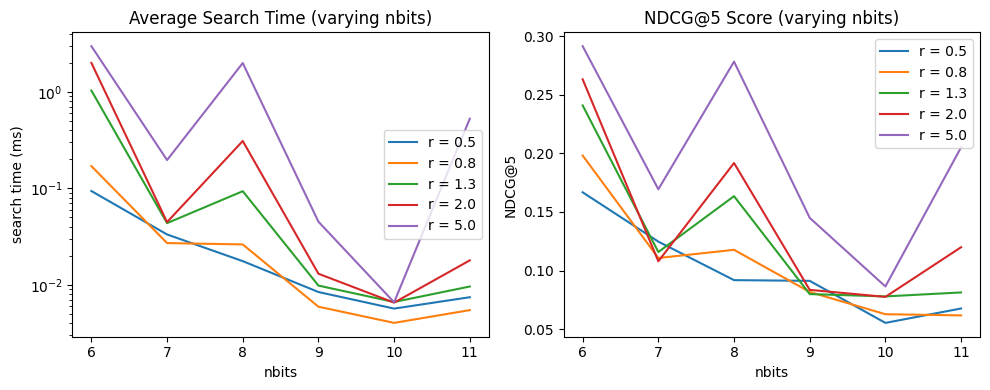

In [8]:
import matplotlib.pyplot as plt

file = open("Results/parameter_optimisation.pkl",'rb')
results = pickle.load(file)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for r in rs:
    speeds = [results[f'r{r}_x{x}']['mean_time'] for x in xs]
    axs[0].plot(xs, speeds, label=f"r = {r}")
    
    scores = [results[f'r{r}_x{x}']['ndcg_5'] for x in xs]
    axs[1].plot(xs, scores, label=f"r = {r}")

axs[0].set_title('Average Search Time (varying nbits)')
axs[0].set_xlabel('nbits')
axs[0].set_ylabel('search time (ms)')
axs[0].set_yscale('log')
axs[0].legend()
axs[1].set_title('NDCG@5 Score (varying nbits)')
axs[1].set_xlabel('nbits')
axs[1].set_ylabel('NDCG@5')
axs[1].legend()

plt.tight_layout()
plt.show()

##### Checking the distribution of r=5

In [37]:
index = LSHIndex(embeddings.shape[1], 5, 8, 100)
index.add(np.arange(embeddings.shape[0]), embeddings)
print(index)

LSHIndex (bin(00111111) = 28, bin(01011111) = 2, bin(01101111) = 67, bin(01110111) = 1, bin(01111011) = 12, bin(01111101) = 3, bin(01111110) = 3, bin(01111111) = 7604, bin(10011111) = 146, bin(10101111) = 24, bin(10110111) = 47, bin(10111101) = 6, bin(10111110) = 25, bin(10111111) = 20346, bin(11001111) = 1, bin(11010101) = 1, bin(11010111) = 13, bin(11011101) = 3, bin(11011110) = 2, bin(11011111) = 1532, bin(11100111) = 5, bin(11101011) = 1, bin(11101101) = 2, bin(11101111) = 3312, bin(11110011) = 1, bin(11110101) = 4, bin(11110110) = 1, bin(11110111) = 798, bin(11111001) = 54, bin(11111011) = 864, bin(11111101) = 1740, bin(11111110) = 521, bin(11111111) = 557868)


In [38]:
index = LSHIndex(embeddings.shape[1], 5, 7, 100)
index.add(np.arange(embeddings.shape[0]), embeddings)
print(index)

LSHIndex (bin(0000000) = 8, bin(0000001) = 19, bin(0000010) = 39, bin(0000011) = 311, bin(0000100) = 20, bin(0000101) = 37, bin(0000110) = 478, bin(0000111) = 1201, bin(0001000) = 27, bin(0001001) = 44, bin(0001010) = 88, bin(0001011) = 559, bin(0001100) = 62, bin(0001101) = 98, bin(0001110) = 197, bin(0001111) = 1895, bin(0010000) = 19, bin(0010001) = 40, bin(0010010) = 80, bin(0010011) = 1132, bin(0010100) = 55, bin(0010101) = 223, bin(0010110) = 284, bin(0010111) = 7612, bin(0011000) = 69, bin(0011001) = 142, bin(0011010) = 376, bin(0011011) = 2867, bin(0011100) = 250, bin(0011101) = 617, bin(0011110) = 1010, bin(0011111) = 15400, bin(0100000) = 19, bin(0100001) = 34, bin(0100010) = 61, bin(0100011) = 385, bin(0100100) = 317, bin(0100101) = 306, bin(0100110) = 441, bin(0100111) = 2767, bin(0101000) = 87, bin(0101001) = 100, bin(0101010) = 167, bin(0101011) = 877, bin(0101100) = 1202, bin(0101101) = 812, bin(0101110) = 608, bin(0101111) = 4505, bin(0110000) = 56, bin(0110001) = 105, 

In [ ]:
index = LSHIndex(embeddings.shape[1], 5, 10, 100)
index.add(np.arange(embeddings.shape[0]), embeddings)
print(index)

LSHIndex (bin(0000000000) = 14, bin(0000000001) = 31, bin(0000000010) = 30, bin(0000000011) = 89, bin(0000000100) = 16, bin(0000000101) = 34, bin(0000000110) = 136, bin(0000000111) = 204, bin(0000001000) = 24, bin(0000001001) = 24, bin(0000001010) = 36, bin(0000001011) = 73, bin(0000001100) = 28, bin(0000001101) = 48, bin(0000001110) = 68, bin(0000001111) = 157, bin(0000010000) = 24, bin(0000010001) = 40, bin(0000010010) = 46, bin(0000010011) = 155, bin(0000010100) = 50, bin(0000010101) = 98, bin(0000010110) = 139, bin(0000010111) = 500, bin(0000011000) = 109, bin(0000011001) = 150, bin(0000011010) = 250, bin(0000011011) = 686, bin(0000011100) = 321, bin(0000011101) = 550, bin(0000011110) = 635, bin(0000011111) = 1934, bin(0000100000) = 20, bin(0000100001) = 26, bin(0000100010) = 78, bin(0000100011) = 125, bin(0000100100) = 100, bin(0000100101) = 110, bin(0000100110) = 234, bin(0000100111) = 315, bin(0000101000) = 16, bin(0000101001) = 30, bin(0000101010) = 45, bin(0000101011) = 97, bi

#### Chosen Parameters

We chose for a slower, but higher NDCG@5 scoring index, where r=5 and nbits=9.
The distribution for this index is not great, but it has a reasonable search time while having a high NDCG@5 score.

In [67]:
index = LSHIndex(embeddings.shape[1], 5, 9, 100)
index.add(np.arange(embeddings.shape[0]), embeddings)
print(index)

LSHIndex (bin(000000001) = 2, bin(000000010) = 3, bin(000000011) = 28, bin(000000100) = 1, bin(000000101) = 4, bin(000000110) = 5, bin(000000111) = 32, bin(000001000) = 1, bin(000001001) = 18, bin(000001010) = 4, bin(000001011) = 64, bin(000001100) = 7, bin(000001101) = 106, bin(000001110) = 76, bin(000001111) = 552, bin(000010001) = 13, bin(000010010) = 5, bin(000010011) = 59, bin(000010100) = 6, bin(000010101) = 32, bin(000010110) = 6, bin(000010111) = 72, bin(000011000) = 1, bin(000011001) = 17, bin(000011010) = 414, bin(000011011) = 199, bin(000011100) = 37, bin(000011101) = 163, bin(000011110) = 423, bin(000011111) = 1799, bin(000100001) = 14, bin(000100011) = 53, bin(000100100) = 4, bin(000100101) = 17, bin(000100110) = 9, bin(000100111) = 63, bin(000101000) = 2, bin(000101001) = 20, bin(000101010) = 15, bin(000101011) = 140, bin(000101100) = 31, bin(000101101) = 152, bin(000101110) = 154, bin(000101111) = 753, bin(000110000) = 1, bin(000110001) = 11, bin(000110010) = 14, bin(000

In [45]:
results[f'r{5.0}_x{9}']

{'num_queries': 20,
 'min_time': 0.0012328280019573868,
 'max_time': 0.19086913200095296,
 'mean_time': 0.0451306346001802,
 'ndcg_5': 0.145}

In [78]:
measure_index_file_stats(index, 'base', embeddings, 5.0, 9)

{'index_creation_ms': 11.097000122070312,
 'save_time_ms': 14.572012186050415,
 'file_size_gb': 1.7069267043843865,
 'load_time_ms': 3.453002452850342}

Takes `11.10s` to create, `14.57s` to save, `1.70GB` size, and `3.45s` to load the index.

## Measurements with Quantizers

#### Scalar Quantization

In [7]:
from quantizers import ScalarQuantizer

quantizer = ScalarQuantizer(embeddings)
scalar_vectors = quantizer.dataset
queries = scalar_vectors[np.random.choice(np.arange(scalar_vectors.shape[0]), 20)]
n = scalar_vectors.shape[0]

In [10]:
index = LSHIndex(scalar_vectors.shape[1], 1.3, 13, 100)
index.add(np.arange(n), scalar_vectors)
print(index)

LSHIndex (bin(0000011100101) = 1, bin(0000011101000) = 1, bin(0000011101001) = 10, bin(0000011101101) = 5, bin(0001010101101) = 1, bin(0001011000001) = 1, bin(0001011000101) = 2, bin(0001011001001) = 1, bin(0001011001101) = 2, bin(0001011100000) = 256, bin(0001011100001) = 1673, bin(0001011100010) = 1, bin(0001011100011) = 11, bin(0001011100100) = 282, bin(0001011100101) = 2057, bin(0001011100110) = 3, bin(0001011100111) = 17, bin(0001011101000) = 2774, bin(0001011101001) = 10285, bin(0001011101010) = 82, bin(0001011101011) = 248, bin(0001011101100) = 3984, bin(0001011101101) = 16850, bin(0001011101110) = 18, bin(0001011101111) = 128, bin(0001011111001) = 1, bin(0001011111100) = 1, bin(0001011111101) = 2, bin(0001111101101) = 4, bin(0010011100000) = 1, bin(0010011100101) = 1, bin(0010011101001) = 7, bin(0010011101100) = 1, bin(0010011101101) = 5, bin(0011010101000) = 1, bin(0011010101100) = 2, bin(0011011000001) = 2, bin(0011011000100) = 1, bin(0011011001000) = 4, bin(0011011001001) = 

In [5]:
import pickle

xs = np.arange(6, 20)

file = open("Results/scalar_results.pkl",'rb')
total_res = pickle.load(file)

for x in xs:
    name = f'scalar_x{x}'
    
    if name in total_res:
        print(f"{name} already measured!")
        continue
    
    index = LSHIndex(scalar_vectors.shape[1], 5, x, 100)
    index.add(np.arange(scalar_vectors.shape[0]), scalar_vectors)
    
    print(f"Measuring x{x}: ", end='')

    dic = measure_index(scalar_vectors, index, queries, name)
    total_res[name] = dic
    print(total_res)
        
with open('Results/scalar_results.pkl', 'wb') as f:
    pickle.dump(total_res, f)
    print('total_res stored')

scalar_x6 already measured!
scalar_x7 already measured!
scalar_x8 already measured!
scalar_x9 already measured!
scalar_x10 already measured!
scalar_x11 already measured!
scalar_x12 already measured!
scalar_x13 already measured!
scalar_x14 already measured!
scalar_x15 already measured!
scalar_x16 already measured!
scalar_x17 already measured!
scalar_x18 already measured!
scalar_x19 already measured!
total_res stored


#### Binary Quantization

In [8]:
from quantizers import BinaryQuantizer

quantizer = BinaryQuantizer(embeddings)
binary_vectors = quantizer.dataset
queries = binary_vectors[np.random.choice(np.arange(binary_vectors.shape[0]), 20)]
n = binary_vectors.shape[0]

In [10]:
binary_vectors

array([[1, 7, 7, ..., 7, 1, 1],
       [7, 1, 7, ..., 7, 1, 1],
       [1, 1, 7, ..., 1, 1, 7],
       ...,
       [1, 7, 1, ..., 1, 7, 7],
       [1, 7, 1, ..., 7, 7, 7],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [ ]:
import pickle

xs = np.arange(6, 20)

file = open("Results/binary_results.pkl",'rb')
total_res = pickle.load(file)

for x in xs:
    name = f'binary_x{x}'
    
    if name in total_res:
        print(f"{name} already measured!")
        continue
    
    index = LSHIndex(binary_vectors.shape[1], 5, x, 100)
    index.add(np.arange(binary_vectors.shape[0]), binary_vectors)
    
    print(f"Measuring x{x}: ", end='')

    dic = measure_index(binary_vectors, index, queries, name)
    total_res[name] = dic
    print(total_res)
        
with open('Results/binary_results.pkl', 'wb') as f:
    pickle.dump(total_res, f)
    print('total_res stored')

#### ProductQuantization

In [13]:
import quantizers
import importlib
importlib.reload(quantizers)
from quantizers import ProductQuantizer

quantizer = ProductQuantizer(embeddings, 192, 768)
product_vectors = quantizer.dataset
queries = product_vectors[np.random.choice(np.arange(product_vectors.shape[0]), 20)]
n = product_vectors.shape[0]

Determined centroids


100%|██████████| 595037/595037 [20:04<00:00, 493.94it/s]


In [12]:
import pickle

xs = np.arange(6, 20)

file = open("Results/product_results.pkl",'rb')
total_res = pickle.load(file)

for x in xs:
    name = f'product_x{x}'
    
    if name in total_res:
        print(f"{name} already measured!")
        continue
    
    index = LSHIndex(product_vectors.shape[1], 5, x, 100)
    index.add(np.arange(product_vectors.shape[0]), product_vectors)
    
    print(f"Measuring x{x}: ", end='')

    dic = measure_index(product_vectors, index, queries, name)
    total_res[name] = dic
    print(total_res)
        
with open('Results/product_results.pkl', 'wb') as f:
    pickle.dump(total_res, f)
    print('total_res stored')

product_x6 already measured!
product_x7 already measured!
product_x8 already measured!
product_x9 already measured!
product_x10 already measured!
product_x11 already measured!
product_x12 already measured!
product_x13 already measured!
product_x14 already measured!
product_x15 already measured!
product_x16 already measured!
product_x17 already measured!
product_x18 already measured!
product_x19 already measured!
total_res stored


#### Comparisons

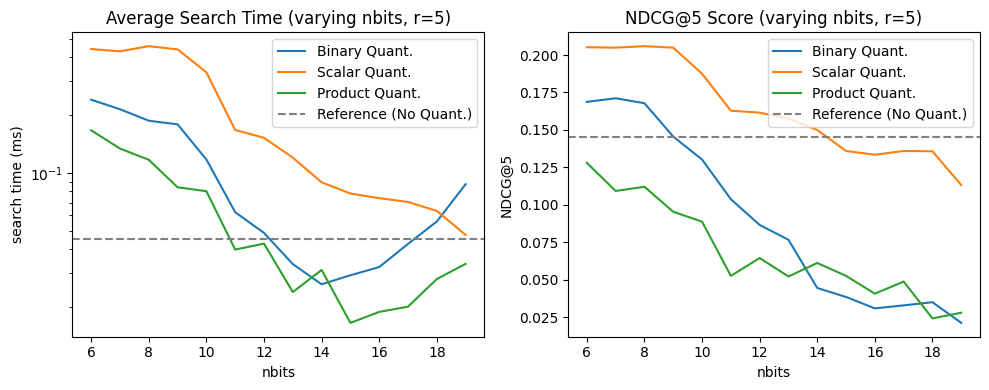

In [13]:
import matplotlib.pyplot as plt
import pickle

xs = np.arange(6, 20)

file = open("Results/binary_results.pkl",'rb')
binary_res = pickle.load(file)

file = open("Results/scalar_results.pkl",'rb')
scalar_res = pickle.load(file)

file = open("Results/product_results.pkl",'rb')
product_res = pickle.load(file)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(xs, [binary_res[f'binary_x{x}']['mean_time'] for x in xs], label = "Binary Quant.")
axs[0].plot(xs, [scalar_res[f'scalar_x{x}']['mean_time'] for x in xs], label = "Scalar Quant.")
axs[0].plot(xs, [product_res[f'product_x{x}']['mean_time'] for x in xs], label = "Product Quant.")

axs[1].plot(xs, [binary_res[f'binary_x{x}']['ndcg_5'] for x in xs], label = "Binary Quant.")
axs[1].plot(xs, [scalar_res[f'scalar_x{x}']['ndcg_5'] for x in xs], label = "Scalar Quant.")
axs[1].plot(xs, [product_res[f'product_x{x}']['ndcg_5'] for x in xs], label = "Product Quant.")

axs[0].set_title('Average Search Time (varying nbits, r=5)')
axs[0].set_xlabel('nbits')
axs[0].set_ylabel('search time (ms)')
axs[0].set_yscale('log')
axs[0].axhline(y=0.0451306346001802, color='gray', linestyle='--', label="Reference (No Quant.)")
axs[0].legend()

axs[1].set_title('NDCG@5 Score (varying nbits, r=5)')
axs[1].set_xlabel('nbits')
axs[1].set_ylabel('NDCG@5')
axs[1].axhline(y=0.145, color='gray', linestyle='--', label="Reference (No Quant.)")
axs[1].legend()

plt.tight_layout()
plt.show()

We chose Binary at nbits = 11, Scalar at nbits = 18, Product at nbits = 8

In [7]:
binary_vectors = np.load('../Data/binary_vectors.npy')
scalar_vectors = np.load('../Data/scalar_vectors.npy')
product_vectors = np.load('../Data/product_vectors.npy')

In [8]:
bin_res = measure_index_file_stats('binary_quant', binary_vectors, 5.0, 11)
sca_res = measure_index_file_stats('scalar_quant', scalar_vectors, 5.0, 18)
pro_res = measure_index_file_stats('product_quant', product_vectors, 5.0, 8)
def_res = measure_index_file_stats('base', embeddings, 5.0, 9)

LSHIndex (bin(00000001000) = 2, bin(00000001001) = 4, bin(00000001010) = 1, bin(00000001011) = 5, bin(00000001101) = 3, bin(00000001111) = 1, bin(00000010000) = 1, bin(00000010011) = 3, bin(00000011000) = 4, bin(00000011001) = 11, bin(00000011010) = 5, bin(00000011011) = 24, bin(00000011111) = 3, bin(00000100000) = 6, bin(00000100001) = 1, bin(00000100010) = 5, bin(00000100011) = 4, bin(00000100100) = 1, bin(00000100101) = 1, bin(00000101000) = 14, bin(00000101001) = 37, bin(00000101010) = 21, bin(00000101011) = 39, bin(00000101100) = 3, bin(00000101101) = 5, bin(00000101110) = 1, bin(00000101111) = 6, bin(00000110000) = 91, bin(00000110001) = 80, bin(00000110010) = 204, bin(00000110011) = 165, bin(00000110100) = 2, bin(00000110101) = 5, bin(00000110110) = 4, bin(00000110111) = 15, bin(00000111000) = 585, bin(00000111001) = 696, bin(00000111010) = 1265, bin(00000111011) = 1493, bin(00000111100) = 36, bin(00000111101) = 55, bin(00000111110) = 68, bin(00000111111) = 88, bin(00001001011) 

In [10]:
import pickle

with open('Results/parameter_optimisation.pkl', 'rb') as f:
    speed_def_res = pickle.load(f)['r5.0_x9']
    
with open('Results/binary_results.pkl', 'rb') as f:
    speed_bin_res = pickle.load(f)['binary_x11']

with open('Results/scalar_results.pkl', 'rb') as f:
    speed_sca_res = pickle.load(f)['scalar_x18']

with open('Results/product_results.pkl', 'rb') as f:
    speed_pro_res = pickle.load(f)['product_x8']

In [25]:
def_map = retrieve_MAP('TREC/Evals/r5.0_x9.txt')
bin_map = retrieve_MAP('TREC/Evals/r5.0_x11.txt')
sca_map = retrieve_MAP('TREC/Evals/scalar_x18.txt')
pro_map = retrieve_MAP('TREC/Evals/product_x8.txt')

In [36]:
import pandas as pd

pd.options.display.float_format = '{:.2f}'.format

df1 = pd.DataFrame.from_dict({'base': def_res, 'binary': bin_res, 'scalar': sca_res, 'product': pro_res})
df1.loc[['file_size_gb']] *= 1000

df2 = pd.DataFrame.from_dict({'base': speed_def_res, 'binary': speed_bin_res, 'scalar': speed_sca_res, 'product': speed_pro_res})
df2 = df2.drop('num_queries')
df2.loc[['min_time', 'max_time', 'mean_time']] *= 1000
df = pd.concat([df1, df2])
df.loc[len(df)] = [def_map, bin_map, sca_map, pro_map]

df = df.rename(columns={'base': 'base (r=5.0, nbits=9)', 'binary': 'binary (r=5.0, nbits=11)', 'scalar': 'scalar (r=5.0, nbits=18)', 'product': 'product (r=5.0, nbits=8)'})
df.index = ['Creation Time (s)', 'Save Time (s)', 'File Size (MB)', 'Load Time (s)', 'Min Time (ms)', 'Max Time (ms)', 'Mean Time (ms)', 'NDCG@5', 'MAP']
df

,"base (r=5.0, nbits=9)","binary (r=5.0, nbits=11)","scalar (r=5.0, nbits=18)","product (r=5.0, nbits=8)"
Creation Time (s),12.55,17.53,14.58,6.95
Save Time (s),161.63,38.91,91.12,17.96
File Size (MB),823.17,50.67,276.68,44.58
Load Time (s),17.02,17.80,11.93,2.85
Min Time (ms),1.23,2.81,2.14,0.55
Max Time (ms),190.87,129.20,170.11,343.32
Mean Time (ms),45.13,62.36,63.34,116.99
NDCG@5,0.14,0.10,0.14,0.11
MAP,0.05,0.09,0.05,0.03


In [37]:
import dataframe_image as dfi

dfi.export(df, 'results_table.png')

In [ ]:
cool_index = LSHIndex.load('Index/lsh_index_product_quant.npz')

CPU times: total: 2.84 s
Wall time: 3.11 s


In [38]:
product_vectors

array([[0, 3, 1, ..., 1, 1, 1],
       [3, 2, 2, ..., 3, 3, 3],
       [3, 3, 1, ..., 0, 1, 3],
       ...,
       [2, 2, 3, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 2],
       [3, 0, 0, ..., 2, 2, 1]], dtype=uint8)